### focus stacking w.r.t. distance from focus

In [1]:
import numpy as np
import subprocess
import glob
import skimage.io as imio
import re
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
%matplotlib inline
import time

## camera behavior
def initialFocus(sid=2):
    #10.42.0.90: local 10.236.176.152: ip
    cmD='ssh -i ~/.ssh/id_rsa_152 nvidia@10.236.176.152 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -init "'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def moveFocus(sid=2, pos=512):
    cmD='ssh -i ~/.ssh/id_rsa_152 nvidia@10.236.176.152 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -mod '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def setFocus(sid=2, pos=512):
    cmD='ssh -i ~/.ssh/id_rsa_152 nvidia@10.236.176.152 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -set '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout

def grab_image(sid=2, imres=8):
# I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images

    subprocess.run('ssh -i ~/.ssh/id_rsa_152 nvidia@10.236.176.152 "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)

    # ok, now let's grab an image on the tegra
    subprocess.run('ssh -i ~/.ssh/id_rsa_152 nvidia@10.236.176.152 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                    --file-name dbGrab --image-res '+str(imres)+'"', stdout=subprocess.PIPE, shell=True)
    subprocess.run('scp -i ~/.ssh/id_rsa_152 nvidia@10.236.176.152:dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
    #pop=skimage.transform.rotate(pop,180)
    subprocess.run('mv dbGrab* photo_arch/', \
                   stdout=subprocess.PIPE, shell=True)
    
    return pop

In [2]:
# initialFocus()
curr = 1000
setFocus(pos = curr)

img = grab_image()
gray_img = rgb2gray(img)

# plt.imshow(gray_img)
# plt.show()
# print(gray_img.max())

In [3]:
from tensorflow.python.keras.models import load_model
dist_est_net = load_model('050-0.65.hdf5')
from quad_solver import solver
#     curr0 = curr + solver(curr, step)[0]
#     curr1 = curr + solver(curr, step)[1]

W1102 10:51:26.501967 140286878349056 deprecation.py:506] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1102 10:51:26.502965 140286878349056 deprecation.py:506] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
## blockwise estimate focus status
def reflect_pad(img, left, up):
    return np.pad(img, ((up, up), (left, left)), 'reflect')

def stack_blocks(img, window_size, step):
    H, W = img.shape
    stack = []
    for i in range(0, H, step):
        for j in range(0, W, step):
            stack.append(img[i:i+window_size, j:j+window_size])
    stack = np.stack(stack)[..., np.newaxis]
    return stack
    
def dist_est(gray_img, curr, last_dist_map = None, last_move_steps = None):
    # dist_list contain blockwise dist it stores. 0 indicates the block has been in-focused before.
    # last_move_steps 
    H, W = gray_img.shape
    window_size = 512
    step = 512
    if H % window_size != 0:
        up = (window_size - (H % window_size))//2
    if W % window_size != 0:
        left = (window_size - (W % window_size))//2
    gray_img = reflect_pad(gray_img, left, up)
    H, W = gray_img.shape

    if last_dist_map is None:
        last_dist_map = np.ones((H//step, W//step))
    
    dist_map = np.zeros(last_dist_map.shape)
      

    gray_img_stack = stack_blocks(gray_img, window_size, step)
    stime = time.time()
    
    dst_stack = dist_est_net.predict(gray_img_stack)
    #print("network runtime elapsed: {}".format(time.time()-stime))
    dst_stack = dst_stack.reshape(H//step, W//step)
    for i in range(H//step):
        for j in range(W//step):
            if last_dist_map[i, j] != 0:
                dst = dst_stack[i, j]
                if dst < 2:
                    dst=0
                dist_map[i, j] = dst

    stime = time.time()
    
    if last_move_steps is not None:
        # step > \delta dist -> next movement direction should be opposite to step
        # step < \delta dist -> next movement direction should be the same as \delta dist
            #\delta dist direction: if (last_dist + last_step - dist) < last_dist
        compare_step_delta = (last_dist_map < np.abs(last_move_steps)).astype(np.float64)
        plt.imshow((compare_step_delta))
        plt.show()
        
        dist_map1 = -dist_map * last_move_steps/np.abs(last_move_steps)
        
            
        diff = np.abs(last_dist_map + last_move_steps - dist_map)
        binary_mask = (diff <= last_dist_map).astype(np.float64) #pos will be marked +1 while neg will be markerd -1
        binary_mask = binary_mask*2-1
        dist_map2 = (dist_map * binary_mask)
        
        dist_map = dist_map1 * compare_step_delta + dist_map2*(1-compare_step_delta)
    


    ## grouping and pick one distance to move
    dist_vec = dist_map.flatten()
    dist_vec = dist_vec[dist_vec!=0]
    n, bins, patches = plt.hist(dist_vec, bins=10)

    idx_sorted = np.argsort(n)[::-1]
    flag = False
    for i in range(len(n)):
        dist_to_move = -(bins[idx_sorted[i]]+bins[idx_sorted[i]+1])/2
        #print("trial {}: est curr: {}".format(i, curr + solver(curr, dist_to_move)))
        if (curr + solver(curr, dist_to_move) > 400) and (curr + solver(curr, dist_to_move) < 1023):
            flag = True
            break
    
    #print("grouping and findmax time elapsed: {}".format(time.time()-stime))
    plt.show()
    plt.imshow((dist_map))
    plt.colorbar()
    plt.show()
    
    return flag, np.abs(dist_map), dist_to_move


In [5]:
dist_map = None
dist_to_move = None
# while (dist_map is None) or (np.max(dist_map) > 1):

round 1 -- current focus pos is: 1000


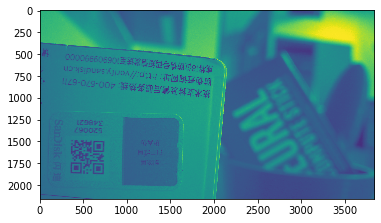

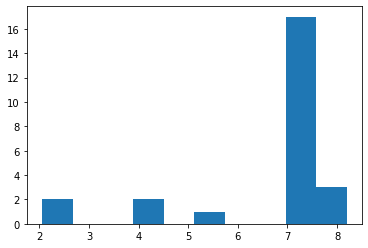

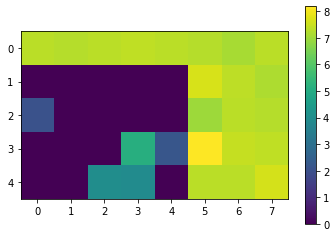

round 2 -- current focus pos is: 553.5866420392947


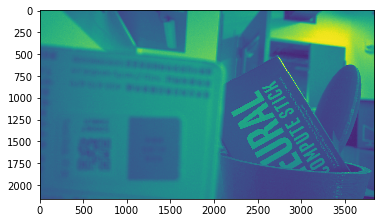

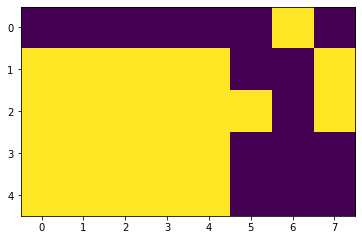

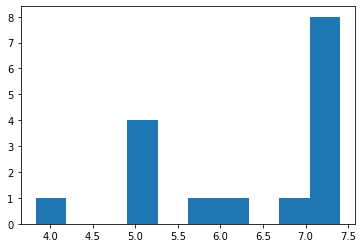

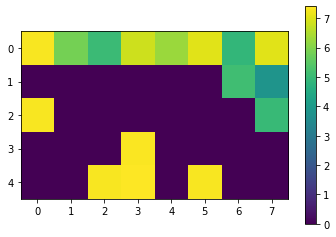

round 3 -- current focus pos is: 409.27564246464743


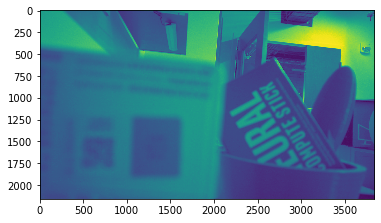

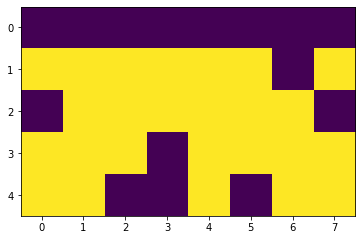

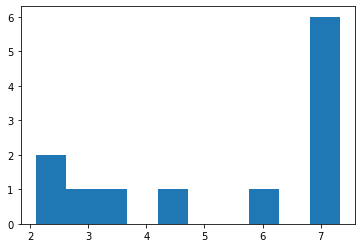

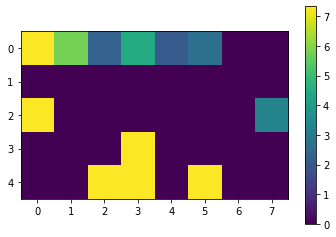

In [6]:
for i in range(6):
    print("round {} -- current focus pos is: {}".format(i+1, curr))
    setFocus(pos = curr)
    img = grab_image()
    gray_img = rgb2gray(img)


    plt.imshow(gray_img)
    plt.show()
    flag, dist_map, dist_to_move = dist_est(gray_img, curr, dist_map, dist_to_move)
    if flag is False:
        break
    curr = curr + solver(curr, dist_to_move)

#     print(dist_map)
#     print(dist_to_move)